Author: Carlos Roberto de Melo
    
Date: 08/10/2020
    
Obj: Modelar os arcos em ESO325 como um _SingularIsothermalEllipse_ (SIE) MassProfile. A fonte será obtida a partir da inversão em uma grid regular. 

In [1]:
#Pacotes necessários/úteis

from autoconf import conf
import autofit as af  # <- This library is used for non-linear fitting.
import autolens as al
import autolens.plot as aplt


from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u
import numpy as np

In [2]:
#Configrando workspace e output files
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

conf.instance = conf.Config(
    config_path=f"{workspace_path}/howtolens/config",
    output_path=f"{workspace_path}/ESO325/Output/SIS-Russell",
)

Workspace Path:  /home/carlos/autolens_workspace


In [3]:
#Reading data

dataset_type = "ESO325"
dataset_name = "Data"
dataset_path = f"{workspace_path}/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/arcs_resized.fits",
    noise_map_path=f"{dataset_path}/noise_map_resized.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.04,
)

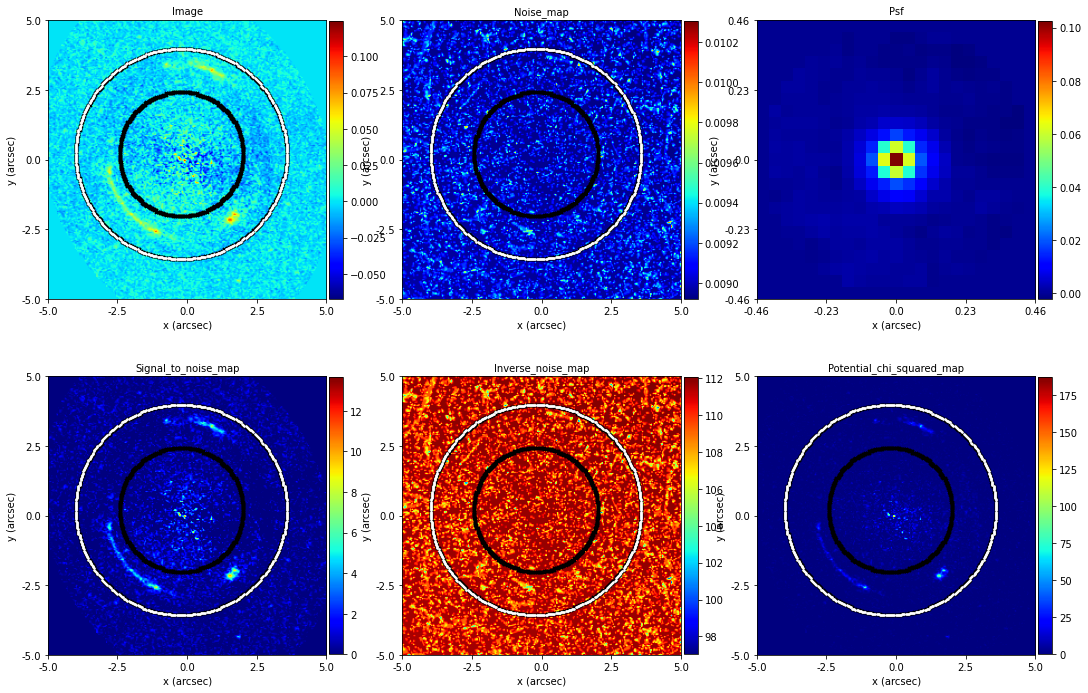

In [4]:
#Criando uma máscara e plotando tudo junto

mask = al.Mask.circular_annular(
    shape_2d=imaging.shape_2d, 
    pixel_scales=imaging.pixel_scales, 
    sub_size=1,
    inner_radius=2.2,
    outer_radius=3.8, 
    centre=(0.2, -0.2)

)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True),
)


In [5]:
elliptical_comps = al.convert.elliptical_comps_from(axis_ratio=1-0.28, phi=158)

print(elliptical_comps)

(-0.11308392077239496, 0.11710182796210596)


In [18]:
#Defining mass profile

mass_profile = al.mp.EllipticalIsothermal(elliptical_comps=elliptical_comps,
    centre=(0.2, 0.1), 
    einstein_radius=2.85, 
)

lens_galaxy = al.Galaxy(
    redshift=0.035, 
    mass=mass_profile,
    
)

print(lens_galaxy)

Redshift: 0.035
Mass Profiles:
EllipticalIsothermal
centre: (0.2, 0.1)
elliptical_comps: (-0.11308392077239496, 0.11710182796210596)
axis_ratio: 0.7199999999999999
phi: -22.00000000000001
einstein_radius: 2.85
slope: 2.0
core_radius: 0.0


In [19]:
#Tracing

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=2.1)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

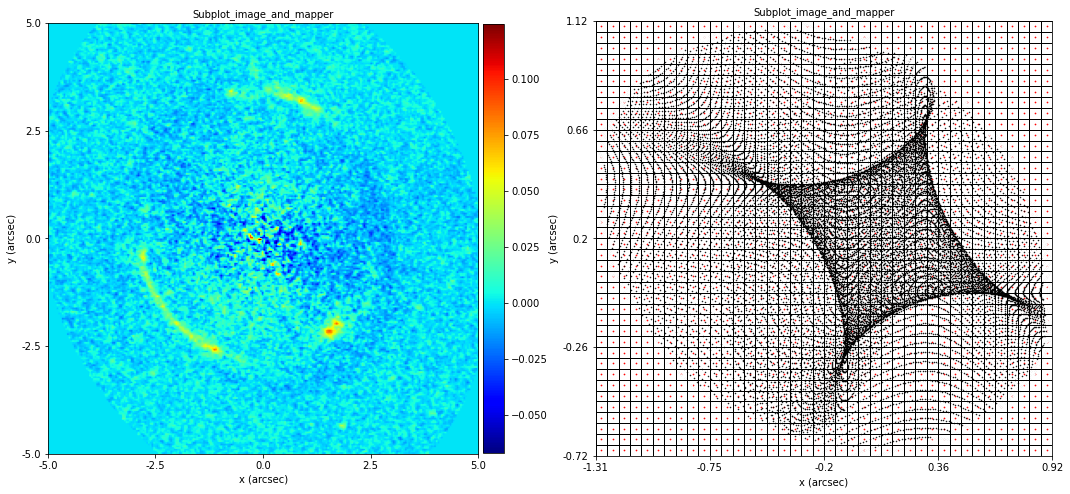

0.8593576540001777


In [20]:
#Rectangular inversion

time = clock()

rectangular = al.pix.Rectangular(shape=(40, 40))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=False, inversion_grid=True),
)

print(clock() - time)

In [24]:
time = clock()

inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=5),
)

print(clock() - time)

1.0200136779999411


In [25]:
#Defining some output configs

sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/ESO325/Output/SIS - Russell/Rectangular',
                                          filename='Rectangular Inversion Plots',
                                          format='png'),        
                              )

plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/ESO325/Output/SIS - Russell/Rectangular',
                                          format='png'),         
                          )

include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )


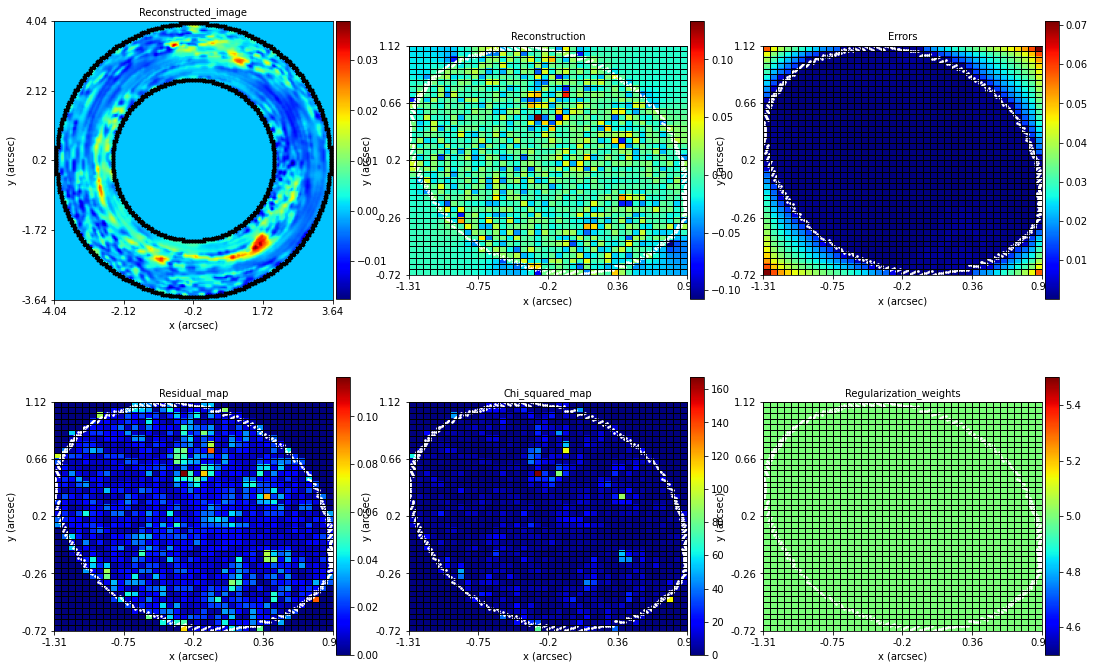

In [26]:
#Ploting

#Ploting Results
aplt.Inversion.subplot_inversion(inversion=inversion,
                                include=(
                                     aplt.Include(
                                               inversion_grid=False, 
                                               inversion_pixelization_grid=False, 
                                               inversion_image_pixelization_grid=False)
                                         ),
                                 sub_plotter=sub_plotter
                                )
 
aplt.Inversion.subplot_inversion(inversion=inversion,
                                include=(
                                     aplt.Include(
                                               inversion_grid=False, 
                                               inversion_pixelization_grid=False, 
                                               inversion_image_pixelization_grid=False)
                                         ),
                                )

In [120]:
#Here we define an usulfull function
def fit_masked_imaging_with_source_galaxy(masked_imaging, source_galaxy):
    mass_profile = al.mp.EllipticalIsothermal(elliptical_comps=elliptical_comps,
    centre=(0.0, 0.0), 
    einstein_radius=3, 
    )

    lens_galaxy = al.Galaxy(
    redshift=0.035, 
    mass=mass_profile,
    
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical NFW/Image Output/ConstVoronoi/',
                                          filename='Constant Voronoi Plots',
                                          format='png'),        
                              )


plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/howtolens/Testes with MGE/Spherical NFW/Image Output/ConstVoronoi/',
                                          format='png'),         
                       )


include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )

In [121]:
time = clock(
)
source_magnification = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(80, 80)),
    regularization=al.reg.Constant(coefficient=1),
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_magnification
)

print(clock() - time)

3.5857037480000145


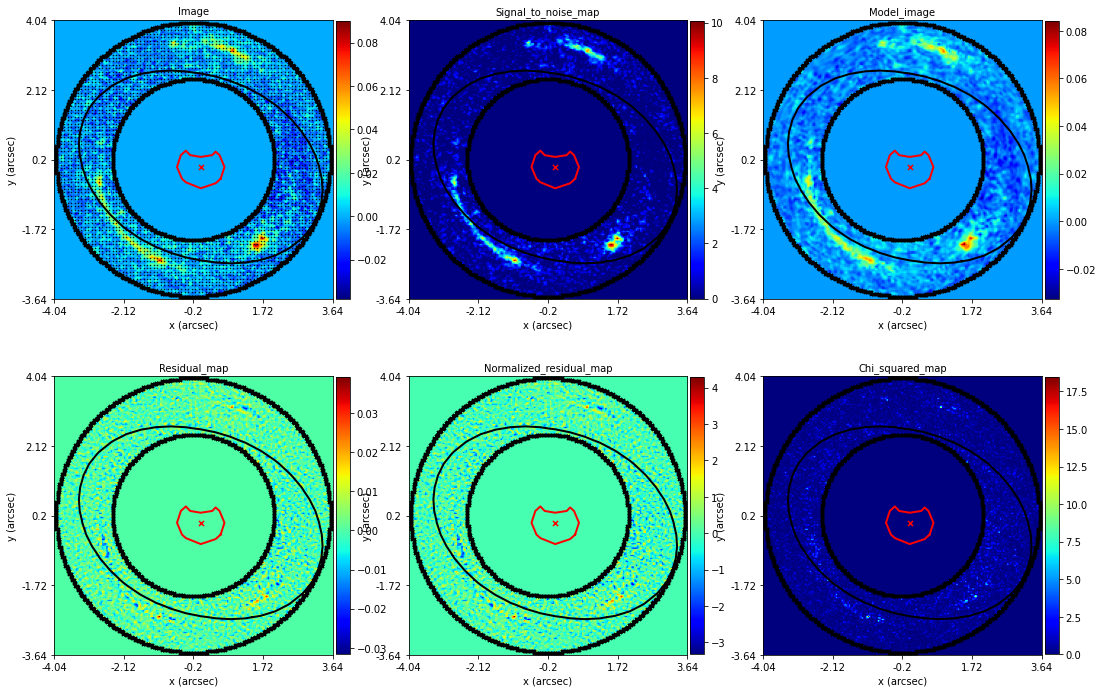

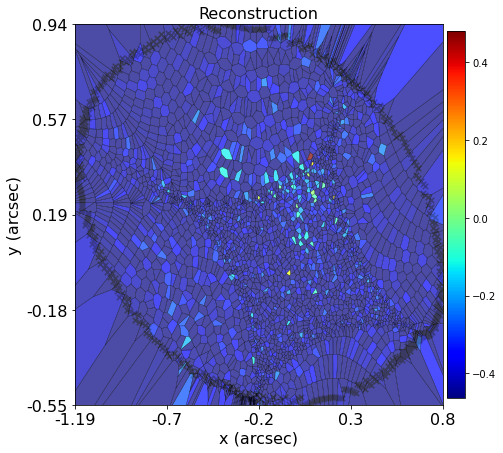

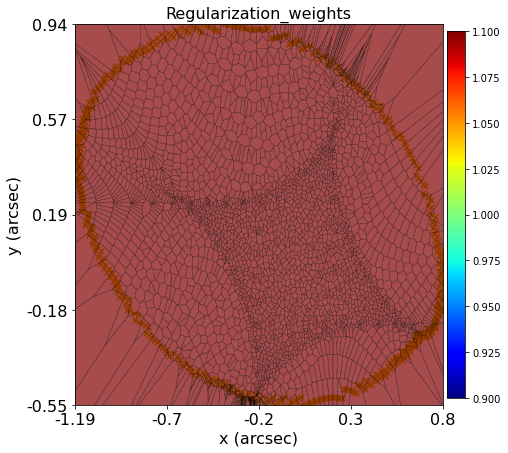

Evidence using adaptive _Regularization_=  57915.996832010074


In [122]:
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    )

aplt.Inversion.individuals(inversion=fit.inversion,
                           include=aplt.Include(inversion_pixelization_grid=False),
                           plot_reconstruction=True, 
                           plot_regularization_weight_map=True,
                           plotter=aplt.Plotter(figure=aplt.Figure(figsize=(7,7)))
                               
                           )

print("Evidence using adaptive _Regularization_= ", fit.log_evidence)
frist_log = fit.log_evidence

In [123]:
hyper_image = fit.model_image.in_1d_binned

source_adaptive_regularization = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(50, 50)),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=3, outer_coefficient=8, signal_scale=3.0
    ),
    hyper_galaxy_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_adaptive_regularization
)

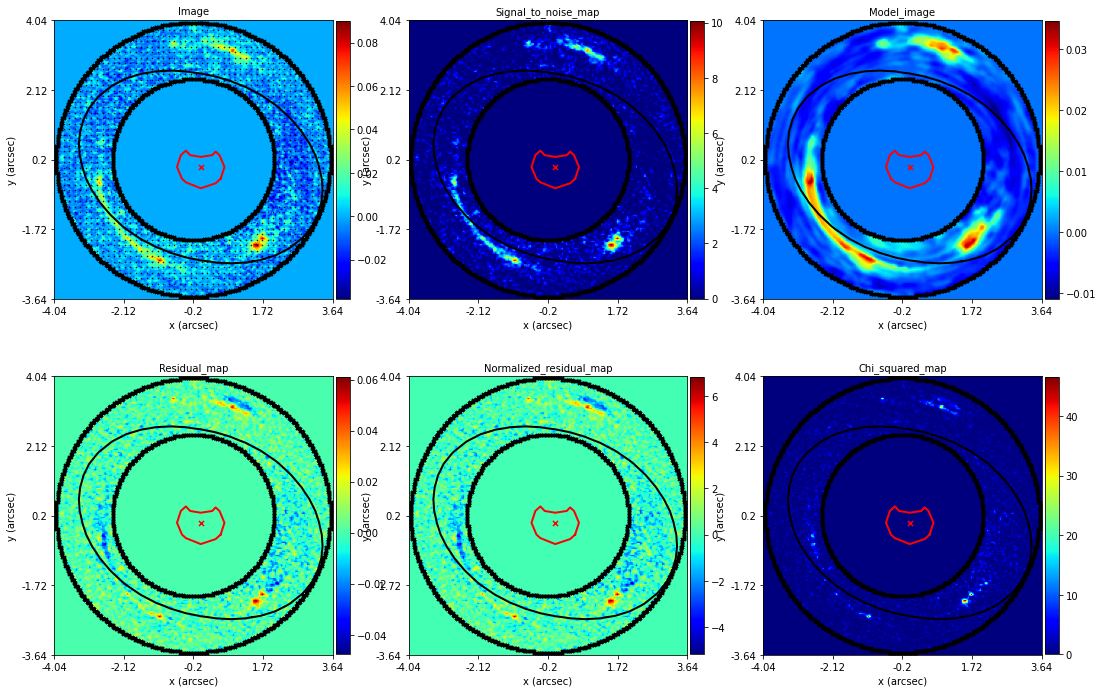

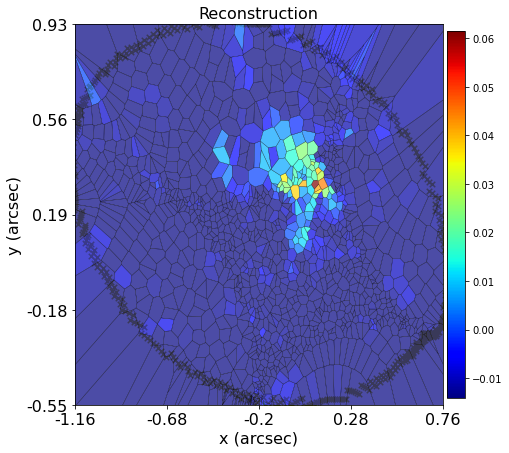

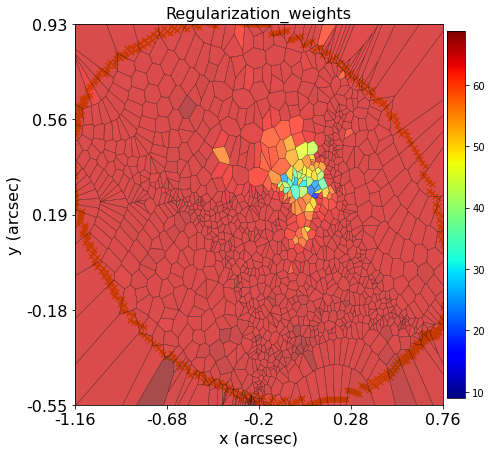

Evidence using adaptive _Regularization_=  63054.4708410228


In [124]:
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    )

aplt.Inversion.individuals(inversion=fit.inversion,
                           include=aplt.Include(inversion_pixelization_grid=False),
                           plot_reconstruction=True, 
                           plot_regularization_weight_map=True,
                           plotter=aplt.Plotter(figure=aplt.Figure(figsize=(7,7)))
                               
                           )

print("Evidence using adaptive _Regularization_= ", fit.log_evidence)